# MODEL FOR SENTIMENT

## Import

In [2]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import re
import time

## Get data

- Data to lable

In [205]:
df = pd.read_csv("C:\Monkeypox\lumos-project\TwitterSentimentAnalysis\Dataset\Annotation\df_to_lable.csv")

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      300 non-null    int64 
 1   created_at      300 non-null    object
 2   hashtags        38 non-null     object
 3   favorite_count  300 non-null    int64 
 4   retweet_count   300 non-null    int64 
 5   lang            300 non-null    object
 6   text            300 non-null    object
dtypes: int64(3), object(4)
memory usage: 16.5+ KB


- The lable

In [3]:
score = pd.read_csv("C:\Monkeypox\lumos-project\TwitterSentimentAnalysis\Dataset\Annotation\Annotation.csv")
score.head()

,Unnamed: 0,yzy,zyr,mjj
0,25443,0,0,0
1,35595,-1,-1,-1
2,139333,-1,-1,-1
3,51580,-1,-1,-1
4,140788,-1,-1,-1


### Preprocesssing

In [208]:
def basic_cleaning(text):
    # clear url
    text = re.sub("(http|https|ftp)://[a-zA-Z0-9\\./]+", '', text)
    # remove tags
    text = re.sub("#(\w+)", " ", text)
    # remove @xxx 
    text = re.sub("(@[(A-Za-z0-9)|_]+)|(\w+:\/\/\S+)", " ", text)
#     # clear not alpha
#     text = re.sub(r'[^a-zA-Z|\s]', '', text)
    return text

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def clean(df):
    for col in ['text']:
        df[col] = df[col].astype(str).apply(lambda x:basic_cleaning(x))
        df[col] = df[col].astype(str).apply(lambda x:remove_html(x))
    return df

In [217]:
df_clean = clean(df)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       300 non-null    int64  
 1   created_at       300 non-null    object 
 2   hashtags         38 non-null     object 
 3   favorite_count   300 non-null    int64  
 4   retweet_count    300 non-null    int64  
 5   lang             300 non-null    object 
 6   text             300 non-null    object 
 7   text_deal_emoji  300 non-null    object 
 8   sentiment        300 non-null    object 
 9   Polarity         300 non-null    float64
 10  Subjectivity     300 non-null    float64
dtypes: float64(2), int64(3), object(6)
memory usage: 25.9+ KB


## Vader

In [210]:
def vader(df,thres1,thres2):
          sid_obj = SentimentIntensityAnalyzer()
          score =[]
          i=0
          for col in df['text']:
                    
                    sentiment_dict = sid_obj.polarity_scores(col)
                    compound = sentiment_dict['compound']
                    if compound>thres1:
                              score.append(1)
                    elif compound <thres2:
                              score.append(-1)
                    else:
                              score.append(0)
          #df.insert(df.shape[1], 'sentiment', vader)
          return score

## Textblob

In [ ]:
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emoji

In [ ]:
df_clean['text_deal_emoji'] = df_clean['text'].astype(str).apply(lambda x: emoji.demojize(x))

In [211]:
def textblob(df,thres1,thres2):
          sid_obj = SentimentIntensityAnalyzer()
          score =[]
          i=0
          for col in df['text_deal_emoji']:
                    sentiment = TextBlob(col).sentiment
                    compound = sentiment[1]
                    if compound>thres1:
                              score.append(1)
                    elif compound <thres2:
                              score.append(-1)
                    else:
                              score.append(0)
          return score

- Test

In [213]:
a = textblob(df_clean,0.5,-0.5)
b = score['mjj']
print(sum(a == b)/300)

0.37


## Optimization

In [ ]:
import time
def f(C):
    a = vader(df_clean,C[0],C[1])
    b = score['mjj']
    r = sum(a==b)/len(a)
    return r

def init(N):
    C = np.zeros((N,2,2))
    global pBest,gBest
    for i in range(N):
        for j in range(2):
            C[i][0][j] = np.random.uniform(-1,1)
            C[i][1][j] = np.random.uniform(-1,1)
        pBest[i] = C[i][0]
    gBest = pBest[np.argmax(Eval(C,N))].copy()
    return C
def whether_out(C):
    for i in range(len(C)):
        for j in range(2):
            if C[i][0][j] < -1 :
                C[i][0][j] = -1
            elif C[i][0][j] > 1:
                C[i][0][j] = 1
    return C
def update_C(C,N,w,c1,c2):
    for i in range(N):
        for j in range(2):
            rand1 = np.random.random()
            rand2 = np.random.random()
            C[i][1][j] = w*C[i][1][j]+c1*rand1*(pBest[i][j]-C[i][0][j])+c2*rand2*(gBest[j]-C[i][0][j])
            C[i][0][j] +=  C[i][1][j]
    C = whether_out(C)
    return C
        
def Eval(C,N):
    temp = np.array([])
    for i in range(N):
        temp = np.append(temp,f(C[i][0]))
    return temp

def update_best(C,N,fitness):
    global pBest,gBest
    for i in range(N):
        if fitness[i] > f(pBest[i]):
            pBest[i] = C[i][0]
        if fitness[i] > f(gBest):
            gBest = C[i][0].copy()
    print('gBest:',gBest)
    print('f(gBest):',f(gBest))

def w_degression(w,N):
    w -= 0.1/N
    return w

def PSO(length,N,w,c1,c2):
    global pBest,gBest
    C = init(N)
    for i in range(length):
        C = update_C(C,N,w,c1,c2)
        fitness = Eval(C,N)
        update_best(C,N,fitness)
        w=w_degression(w,N)
        if f(gBest)==1.0:
            break
    return [f(gBest),gBest,i]

start = time.time()
c1,c2 = 2,2
length,N=100,10
w=0.9
pBest = np.zeros((N,2))
gBest = np.zeros(N)
end = time.time()
print(PSO(length,N,w,c1,c2))
print('PSO运行时间: %.2f s'%(end-start))


gBest: [ 0.81498005 -0.04960461]
f(gBest): 0.5466666666666666
gBest: [ 0.81498005 -0.04960461]
f(gBest): 0.5466666666666666
gBest: [ 0.61558797 -0.09694701]
f(gBest): 0.5533333333333333
gBest: [ 0.61558797 -0.09694701]
f(gBest): 0.5533333333333333
gBest: [ 0.61558797 -0.09694701]
f(gBest): 0.5533333333333333
gBest: [ 0.61558797 -0.09694701]
f(gBest): 0.5533333333333333
gBest: [ 0.61558797 -0.09694701]
f(gBest): 0.5533333333333333
gBest: [ 0.7113991  -0.03736337]
f(gBest): 0.5566666666666666
gBest: [ 0.7113991  -0.03736337]
f(gBest): 0.5566666666666666
gBest: [ 0.7113991  -0.03736337]
f(gBest): 0.5566666666666666
gBest: [ 0.7113991  -0.03736337]
f(gBest): 0.5566666666666666
gBest: [ 0.7113991  -0.03736337]
f(gBest): 0.5566666666666666
gBest: [ 0.69024634 -0.02222784]
f(gBest): 0.56
gBest: [ 0.69024634 -0.02222784]
f(gBest): 0.56
gBest: [ 0.69024634 -0.02222784]
f(gBest): 0.56
gBest: [ 0.69024634 -0.02222784]
f(gBest): 0.56
gBest: [ 0.38507686 -0.02076075]
f(gBest): 0.5733333333333334
gB

- Kappa

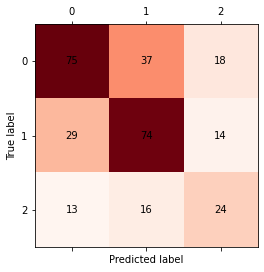

kappa值为 0.331145


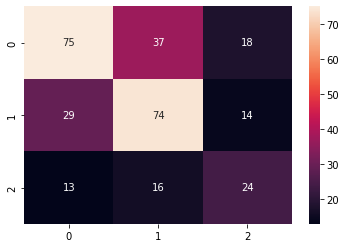

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
y_pred = vader(df_clean,0.39,-0) 
y_true = score['mjj'].values.tolist() 

C = confusion_matrix(y_true, y_pred, labels=[-1,0,1]) 
plt.matshow(C, cmap=plt.cm.Reds) 

for i in range(len(C)):
    for j in range(len(C)):
        plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')

plt.ylabel('True label')
plt.xlabel('Predicted label')
sns.heatmap(C,annot=True)
kappa_value = cohen_kappa_score(y_true, y_pred)
print("kappa值为 %f" % kappa_value)


# Get the sentiment pie chart

### Get dataset

In [ ]:
df_all = pd.read_csv("C:\Monkeypox\lumos-project\TwitterSentimentAnalysis\Dataset\ReadableTweets\monkeypoxTweetsDataset.csv")

### Choose English

In [ ]:
language = df_all.value_counts(subset='lang')
print(language)
df_en = df_all.loc[df['lang'] == 'en']
clean(df_en)

lang
en     199110
fr       2631
es       2225
pt       1565
qme      1544
        ...  
uk          4
bg          4
ps          2
sd          1
ckb         1
Length: 65, dtype: int64


,Unnamed: 0,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
0,0,NaN,Sat May 21 21:51:16 +0000 2022,NaN,NaN,https://warroom.org/2022/05/21/episode-1874-wh...,28,1528131335742705665,NaN,NaN,...,57368,835,1453,Global -- Currently on Earth,Michael Yon,Michael_Yon,59871,NaN,http://www.michaelyon.com,False
1,1,NaN,Sat May 21 22:25:48 +0000 2022,NaN,NaN,NaN,0,1528140025623646208,imispgh,1.528139e+18,...,787,4852,9,Origin🌳US + in 155 countries.,@AILovesTech®️🔑🚘,AILoves_Jackie9,21789,NaN,https://twitter.com/@T_W_T_R_Wallet,False
2,2,NaN,Sat May 21 22:24:39 +0000 2022,NaN,NaN,NaN,1,1528139737957126144,NaN,NaN,...,180,899,2,NaN,Mikey,MikeyNYI,6435,NaN,NaN,False
3,3,NaN,Sat May 21 22:27:59 +0000 2022,NaN,NaN,NaN,0,1528140577320996864,PeteUK7,1.528108e+18,...,2213,3077,48,Unceded Lək̓ʷəŋən Nations Land,David D. 🟧 🪶 🟧,answerallman,334792,NaN,https://twitter.com/answerallman/status/134144...,False
4,4,NaN,Sat May 21 22:24:11 +0000 2022,NaN,NaN,NaN,2,1528139620176625664,vancemurphy,1.528060e+18,...,4193,4994,3,NaN,MAGA B,MAGAB07910508,36256,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216516,216516,NaN,Sat Jul 23 00:00:17 +0000 2022,NaN,NaN,https://www.cdc.gov/poxvirus/monkeypox/transmi...,1,1550631852393828352,NaN,NaN,...,527,971,21,NaN,Wendy,wmzraz,41768,NaN,NaN,False
216517,216517,NaN,Sat Jul 23 00:00:00 +0000 2022,NaN,NaN,https://endpts.com/bavarian-nordics-monkeypox-...,4,1550631781396729856,NaN,NaN,...,24292,40,528,Global,Endpoints News,endpts,44700,NaN,http://endpts.com,False
216518,216518,NaN,Sat Jul 23 00:00:18 +0000 2022,Monkeypox HealthierJC,https://twitter.com/HealthierJC/status/1550631...,NaN,0,1550631856336506886,NaN,NaN,...,2312,1582,32,"Jersey City, NJ",Healthier JC,HealthierJC,7892,NaN,http://healthierjc.com,False
216519,216519,NaN,Sat Jul 23 00:00:23 +0000 2022,NaN,NaN,https://twitter.com/i/broadcasts/1OdKrBzXyMQKX,0,1550631877781835776,NaN,NaN,...,1817,939,34,Los Angeles,(((Luke Ford))),lukeford,61391,NaN,http://www.lukeford.net,False


In [ ]:
df_time = df_en[['created_at','text']]
df_time.info()
df_time.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199110 entries, 0 to 216520
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   created_at  199110 non-null  object
 1   text        199110 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


,created_at,text
0,Sat May 21 21:51:16 +0000 2022,Watch the progressive monkeys run out screamin...
1,Sat May 21 22:25:48 +0000 2022,When you have Bill Gates shorting Tesla for ...
2,Sat May 21 22:24:39 +0000 2022,"Monkey pox as reported by Reuters \n\n“Gay, bi..."
3,Sat May 21 22:27:59 +0000 2022,Hey Pete\nPeople are crazy 'Busy'\nWe can't ...
4,Sat May 21 22:24:11 +0000 2022,"Well, you know the new thing is monkey..."
5,Sat May 21 22:25:07 +0000 2022,Disease Detection: Laboratories on the front l...
7,Sat May 21 22:22:00 +0000 2022,This monkey pox is starting to give me early 2...
8,Sat May 21 22:30:10 +0000 2022,So reading on how this monkey pox virus spread...
9,Sat May 21 22:25:48 +0000 2022,Monkey pox
10,Sat May 21 22:21:30 +0000 2022,"Monkey Pox, by"


In [ ]:
sen = vader(df_time,0.39,-0)

In [ ]:
from datetime import datetime

df_time['created_at']= df_time['created_at'].apply(lambda dtime: datetime.strftime(datetime.strptime(dtime,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S'))
df_time['created_at']= pd.to_datetime(df_time['created_at'])

In [ ]:
def sentiment(df):
    sid_obj = SentimentIntensityAnalyzer()
    vader =[]
    for col in df['text']:
        sentiment_dict = sid_obj.polarity_scores(col)
        compound = sentiment_dict['compound']
        vader.append(compound)
    df.insert(df.shape[1], 'sentiment', vader)
    return df

In [ ]:
sort_time = sentiment(df_time).sort_values(by="created_at")

In [ ]:
(sort_time['created_at']<='2022-05-7 23:59:59').value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199110 entries, 128536 to 161206
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   created_at  199110 non-null  datetime64[ns]
 1   text        199110 non-null  object        
 2   sentiment   199110 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.1+ MB


,created_at,text,sentiment
128536,2011-05-13 00:47:54,I HAVE NEVER AND WILL NEVER APOLOGISE FOR MY S...,0.7198
202853,2012-04-27 04:16:52,"Monkeypox on Delta 3163, quarantined in Chicag...",-0.6808
130127,2018-06-22 17:24:47,If you are terrified of confined spaces and fa...,0.0000
73510,2019-05-18 16:37:43,We have a lot of photographs in our collection...,-0.1154
162431,2019-05-18 16:37:43,We have a lot of photographs in our collection...,-0.1154
...,...,...,...
58366,2022-04-20 18:56:58,Members of America First may think they have h...,-0.5866
67935,2022-04-27 16:02:45,Two years of dealing with Covid-19 have made p...,-0.4404
27288,2022-04-27 16:02:45,Two years of dealing with Covid-19 have made p...,-0.4404
44466,2022-05-02 20:28:36,I am just fine if Canada is an outlier here....,-0.6647


[75193, 88285, 35632]


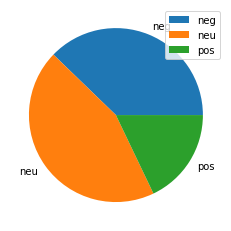

In [ ]:
neg = sen.count(-1)
pos = sen.count(1)
neu = sen.count(0)
pie = [neg,neu,pos]
print(pie)
plt.pie(pie,labels=["neg","neu","pos"])
plt.legend()
plt.show()

- Fleiss Kappa

In [ ]:
marix =np.zeros((300, 3))
name = ['yzy','zyr','mjj']
i=0
while i<300:
          for j in name:
                    if score[j][i]==-1:
                              marix[i][0] = marix[i][0]+1
                    elif score[j][i]==0:
                              marix[i][1] = marix[i][1]+1
                    else:
                              marix[i][2] = marix[i][2]+1
          i = i+1
print(marix)

[[0. 3. 0.]
 [3. 0. 0.]
 [3. 0. 0.]
 [3. 0. 0.]
 [3. 0. 0.]
 [3. 0. 0.]
 [1. 2. 0.]
 [3. 0. 0.]
 [0. 2. 1.]
 [3. 0. 0.]
 [0. 3. 0.]
 [0. 3. 0.]
 [0. 2. 1.]
 [3. 0. 0.]
 [0. 0. 3.]
 [2. 0. 1.]
 [0. 3. 0.]
 [1. 2. 0.]
 [2. 0. 1.]
 [1. 2. 0.]
 [0. 2. 1.]
 [1. 2. 0.]
 [0. 1. 2.]
 [3. 0. 0.]
 [0. 2. 1.]
 [2. 1. 0.]
 [1. 1. 1.]
 [3. 0. 0.]
 [0. 3. 0.]
 [0. 3. 0.]
 [3. 0. 0.]
 [1. 2. 0.]
 [0. 3. 0.]
 [0. 3. 0.]
 [1. 2. 0.]
 [2. 1. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [0. 3. 0.]
 [0. 3. 0.]
 [2. 1. 0.]
 [0. 3. 0.]
 [2. 1. 0.]
 [0. 3. 0.]
 [1. 2. 0.]
 [0. 3. 0.]
 [2. 1. 0.]
 [0. 3. 0.]
 [0. 3. 0.]
 [1. 2. 0.]
 [3. 0. 0.]
 [3. 0. 0.]
 [0. 3. 0.]
 [0. 3. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [0. 3. 0.]
 [0. 3. 0.]
 [0. 3. 0.]
 [0. 2. 1.]
 [0. 3. 0.]
 [0. 3. 0.]
 [1. 2. 0.]
 [3. 0. 0.]
 [0. 2. 1.]
 [0. 2. 1.]
 [1. 2. 0.]
 [1. 2. 0.]
 [2. 0. 1.]
 [2. 1. 0.]
 [0. 1. 2.]
 [3. 0. 0.]
 [1. 2. 0.]
 [0. 3. 0.]
 [0. 1. 2.]
 [2. 1. 0.]
 [1. 2. 0.]
 [0. 3. 0.]
 [0. 0. 3.]
 [0. 3. 0.]
 [2. 1. 0.]
 [0. 3. 0.]
 [0. 2. 1.]
 [1.

In [ ]:
def fleiss_kappa(testData, N, k, n):
    dataMat = np.mat(testData, float)
    oneMat = np.ones((k, 1))
    sum = 0.0
    P0 = 0.0
    for i in range(N):
        temp = 0.0
        for j in range(k):
            sum += dataMat[i, j]
            temp += 1.0*dataMat[i, j]**2
        temp -= n
        temp /= (n-1)*n
        P0 += temp
    P0 = 1.0*P0/N
    ysum = np.sum(dataMat, axis=0)
    for i in range(k):
        ysum[0, i] = (ysum[0, i]/sum)**2
    Pe = ysum*oneMat*1.0
    ans = (P0-Pe)/(1-Pe)
    return ans[0, 0]

print(fleiss_kappa(marix, 300, 3, 3))


0.43648362314382216


In [ ]:
df.to_json('C:\Monkeypox\lumos-project\TwitterSentimentAnalysis\Dataset\Annotation\day_score.json',orient='records')

In [290]:
n = [[],[],[]]
for i in sort_time['score']:
          if i == 1:
                    n[0].append(0)
                    n[1].append(0)
                    n[2].append(1)
          elif i == 0:
                    n[0].append(0)
                    n[1].append(1)
                    n[2].append(0)
          else:
                    n[0].append(1)
                    n[1].append(0)
                    n[2].append(0)
sort_time['neg'] = n[0]
sort_time['neu'] = n[1]
sort_time['pos'] = n[2]
sort_time.info()
sort_time.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199110 entries, 128536 to 161206
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   created_at  199110 non-null  datetime64[ns]
 1   text        199110 non-null  object        
 2   sentiment   199110 non-null  float64       
 3   score       199110 non-null  int64         
 4   -1          2 non-null       float64       
 5   neg         199110 non-null  int64         
 6   neu         199110 non-null  int64         
 7   pos         199110 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 13.7+ MB


,created_at,text,sentiment,score,-1,neg,neu,pos
128536,2011-05-13 00:47:54,I HAVE NEVER AND WILL NEVER APOLOGISE FOR MY S...,0.7198,1,NaN,0,0,1
202853,2012-04-27 04:16:52,"Monkeypox on Delta 3163, quarantined in Chicag...",-0.6808,-1,NaN,1,0,0
130127,2018-06-22 17:24:47,If you are terrified of confined spaces and fa...,0.0000,0,NaN,0,1,0
73510,2019-05-18 16:37:43,We have a lot of photographs in our collection...,-0.1154,-1,NaN,1,0,0
162431,2019-05-18 16:37:43,We have a lot of photographs in our collection...,-0.1154,-1,NaN,1,0,0


In [303]:
df_new=sort_time.groupby([pd.Grouper(key='created_at',freq='W')])[['neg']].sum().reset_index()
time_clean = df_new.dropna(how = 'any')
time_clean.head(200)
time_clean[573:585]

,created_at,neg
573,2022-05-08,5
574,2022-05-15,2
575,2022-05-22,2260
576,2022-05-29,3413
577,2022-06-05,2905
578,2022-06-12,5417
579,2022-06-19,4567
580,2022-06-26,4175
581,2022-07-03,6415
582,2022-07-10,5832


In [304]:
df_new1=sort_time.groupby([pd.Grouper(key='created_at',freq='W')])[['pos']].sum().reset_index()
time_clean1 = df_new1.dropna(how = 'any')
time_clean1.head(200)
time_clean1[573:585]

,created_at,pos
573,2022-05-08,1
574,2022-05-15,5
575,2022-05-22,1231
576,2022-05-29,1866
577,2022-06-05,1922
578,2022-06-12,3709
579,2022-06-19,2681
580,2022-06-26,2633
581,2022-07-03,3513
582,2022-07-10,3151


In [309]:
df_new2=sort_time.groupby([pd.Grouper(key='created_at',freq='W')])[['neu']].sum().reset_index()
time_clean2 = df_new2.dropna(how = 'any')
time_clean2.head(200)
time_clean2[573:585]

,created_at,neu
573,2022-05-08,0
574,2022-05-15,1
575,2022-05-22,3081
576,2022-05-29,5217
577,2022-06-05,4142
578,2022-06-12,7598
579,2022-06-19,5893
580,2022-06-26,6053
581,2022-07-03,10141
582,2022-07-10,8993


In [334]:
df_new3=sort_time.groupby([pd.Grouper(key='created_at',freq='D')])[['sentiment']].mean().reset_index()
time_clean3 = df_new3.dropna(how = 'any')
time_clean3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 4089
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   created_at  178 non-null    datetime64[ns]
 1   sentiment   178 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.2 KB


In [238]:
s = []
for i in time_clean['sentiment']:
          if i < -0.00:
                    s.append(-1)
          elif i >0.39:
                    s.append(1)
          else:
                    s.append(0)
time_clean['score'] = s
time_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 4089
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   created_at  178 non-null    datetime64[ns]
 1   sentiment   178 non-null    float64       
 2   score       178 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 5.6 KB
